In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
import numpy as np
import optuna
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


data= pd.read_csv('1dataset.csv')

# Создадим таблицу для вывода
А также функцию, добавляющую метрики в датафрейм

In [50]:
table_all_metrics = pd.DataFrame(columns=['Model','MAE','MSE','RMSE','MAPE','R^2'])

In [17]:
def add_err_to_dataframe(dataframe, model_name, dict_errors):
    new_row = {'Model': model_name}
    
    # Добавляем ошибки в строку
    for error, value in dict_errors.items():
        new_row[error] = value
    
    # Добавляем строку в DataFrame .loc[] используется для доступа к строкам по метке.
    # Таким образом, она указывает на новую позицию после последней строки.
    
    dataframe.loc[len(dataframe)] = new_row

# Линейная регрессия

In [51]:
# Разделение на признаки и целевую переменную
y = data["price"]
X = data.drop(["price"], axis=1)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
lr = LinearRegression().fit(X_train, y_train)

# Предсказание
y_pred = lr.predict(X_test)


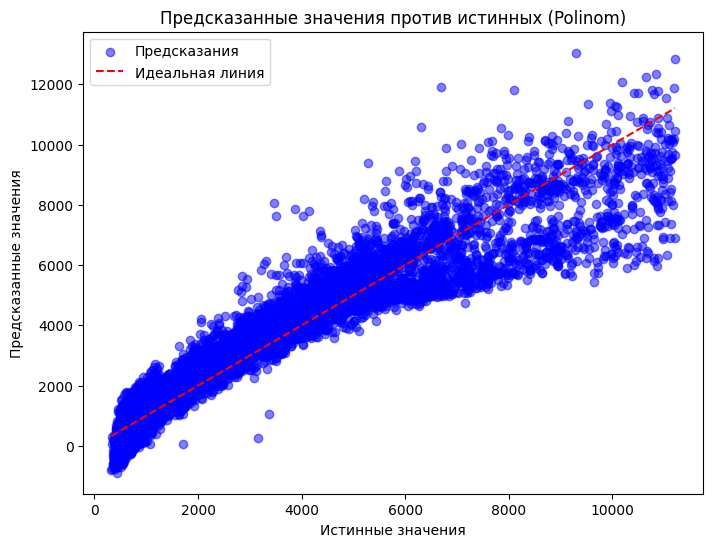

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

Напишем функции, которые добавят метрики в таблицу

In [53]:
def dict_errors(y_pred, y_test):
  return {'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': sqrt(mean_absolute_percentage_error(y_test, y_pred)),
          'R^2': r2_score(y_test, y_pred)}

In [54]:
this_dict_errors = dict_errors(y_pred, y_test)
add_err_to_dataframe(table_all_metrics, 'Linear_regression', this_dict_errors)
print(this_dict_errors)

{'MAE': 561.4397703105604, 'MSE': 670719.300001884, 'RMSE': 818.9745417300126, 'MAPE': 0.5517882062444024, 'R^2': 0.903072854355253}


In [22]:
print(lr.coef_)
print(lr.intercept_)

[ 1.27688561e+04  4.80733778e+01  1.35940577e+02  3.38770849e+02
  4.21937809e+03  6.12573590e+01 -4.63392395e+03  6.57981003e+04
 -7.79955510e+04  8.55841125e+05]
-2450.8377377352276


# L1 регрессия, она же Лассо

In [23]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Lasso(), alpha_values).fit(X_train, y_train)
y_pred_lasso_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 568.9363566658985, 'MSE': 683407.2728115125, 'RMSE': 826.6845062123231, 'MAPE': 0.5594405459520482, 'R^2': 0.9012392870366265}


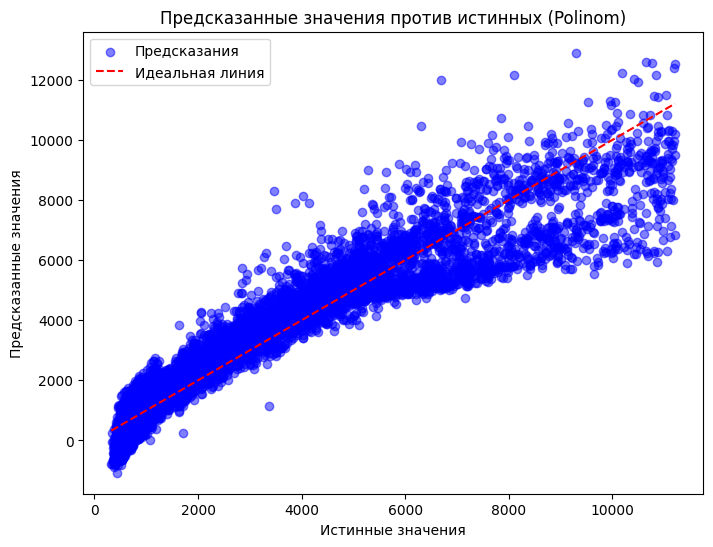

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [25]:
random_search = RandomizedSearchCV(
        Lasso(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_lasso_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 568.9363566658985, 'MSE': 683407.2728115125, 'RMSE': 826.6845062123231, 'MAPE': 0.5594405459520482, 'R^2': 0.9012392870366265}


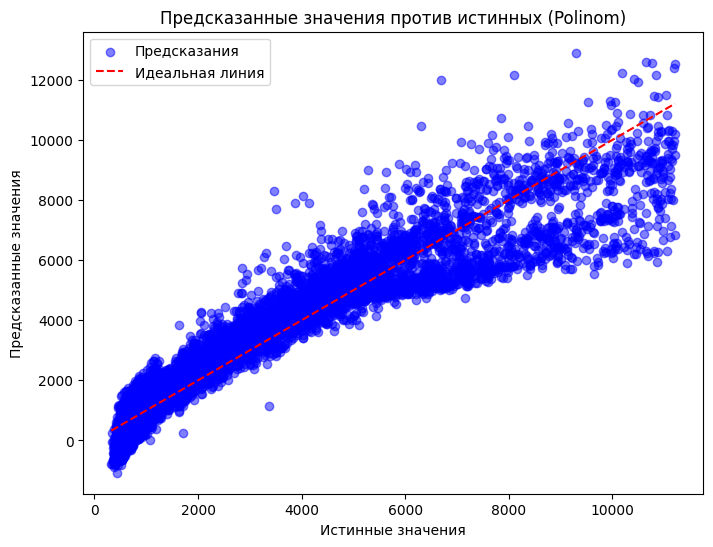

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [27]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_lasso(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    lasso = Lasso(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [28]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_lasso, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
lasso = Lasso(**best_params)
lasso.fit(X_train, y_train)
y_pred_lasso_optuna = lasso.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_optuna', this_dict_errors)
print(this_dict_errors)


[I 2025-04-07 22:14:17,209] A new study created in memory with name: no-name-6db36619-e965-42ef-ba05-089b4549efdd
[I 2025-04-07 22:14:18,034] Trial 0 finished with value: -685436.7554039132 and parameters: {'alpha': 0.24745791820036986}. Best is trial 0 with value: -685436.7554039132.
[I 2025-04-07 22:14:18,865] Trial 1 finished with value: -796038.6210874252 and parameters: {'alpha': 17.52787772712826}. Best is trial 0 with value: -685436.7554039132.
[I 2025-04-07 22:14:19,916] Trial 2 finished with value: -683772.2358066499 and parameters: {'alpha': 0.09927746659200896}. Best is trial 2 with value: -683772.2358066499.
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.878e+09, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_

{'MAE': 561.781570285478, 'MSE': 671544.0593009932, 'RMSE': 819.477918739116, 'MAPE': 0.5526561797793268, 'R^2': 0.9029536665449329}


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+10, tolerance: 2.608e+07
  model = cd_fast.enet_coordinate_descent(


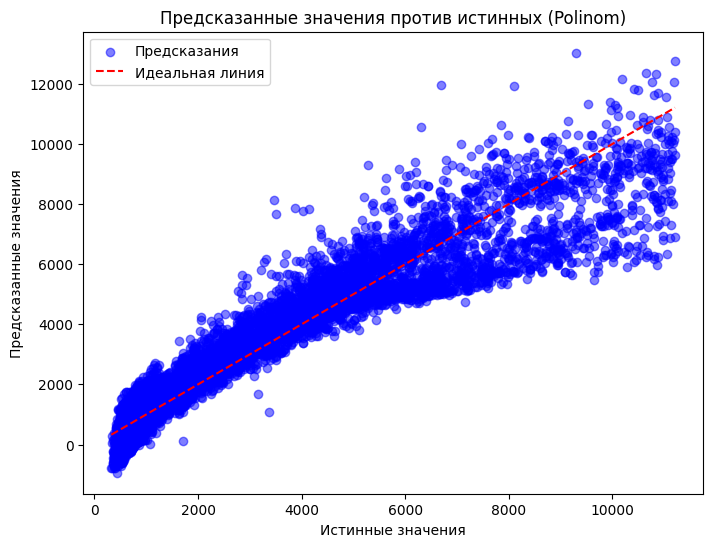

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# L2 (Ridge)

In [30]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Ridge(), alpha_values).fit(X_train, y_train)
y_pred_ridge_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 567.8878532575194, 'MSE': 682353.1254677525, 'RMSE': 826.0466847992021, 'MAPE': 0.5584346056224383, 'R^2': 0.9013916242261473}


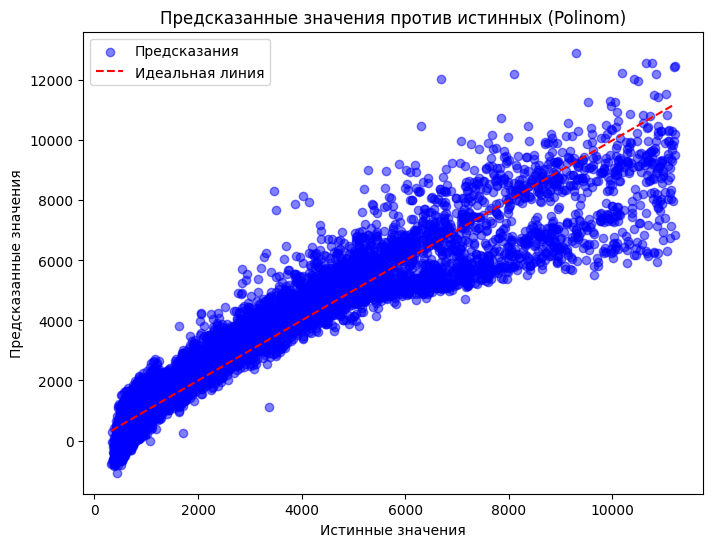

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [32]:
random_search = RandomizedSearchCV(
        Ridge(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_ridge_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 567.8878532575194, 'MSE': 682353.1254677525, 'RMSE': 826.0466847992021, 'MAPE': 0.5584346056224383, 'R^2': 0.9013916242261473}


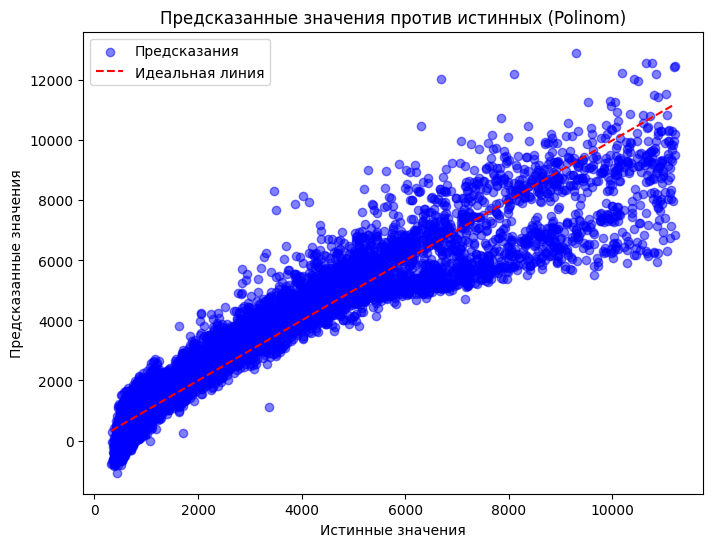

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [34]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_ridge(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    ridge = Ridge(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [35]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_ridge, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
ridge = Ridge(**best_params)
ridge.fit(X_train, y_train)
y_pred_ridge_optuna = ridge.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'ridge_optuna', this_dict_errors)
print(this_dict_errors)

[I 2025-04-07 22:15:13,306] A new study created in memory with name: no-name-b707c9a4-6190-4e76-b285-7cf7075b8342
[I 2025-04-07 22:15:13,337] Trial 0 finished with value: -685507.7323949646 and parameters: {'alpha': 0.38426787845649685}. Best is trial 0 with value: -685507.7323949646.
[I 2025-04-07 22:15:13,364] Trial 1 finished with value: -682721.0321145642 and parameters: {'alpha': 0.05616548168992073}. Best is trial 1 with value: -682721.0321145642.
[I 2025-04-07 22:15:13,391] Trial 2 finished with value: -786382.5467396951 and parameters: {'alpha': 14.737232880036292}. Best is trial 1 with value: -682721.0321145642.
[I 2025-04-07 22:15:13,418] Trial 3 finished with value: -682701.8710297185 and parameters: {'alpha': 0.0547025895076352}. Best is trial 3 with value: -682701.8710297185.
[I 2025-04-07 22:15:13,445] Trial 4 finished with value: -810729.5673102676 and parameters: {'alpha': 23.36866252574094}. Best is trial 3 with value: -682701.8710297185.
[I 2025-04-07 22:15:13,472] Tr

{'MAE': 564.5427542124877, 'MSE': 675715.5820284986, 'RMSE': 822.0192102551489, 'MAPE': 0.5555338031978497, 'R^2': 0.9023508304688455}


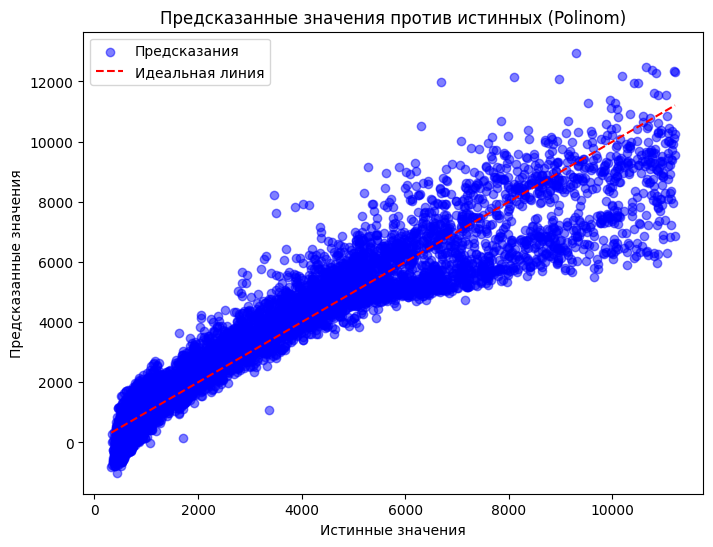

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Elastic Net (линейная регрессия с двумя регуляризаторами)

In [37]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(ElasticNet(), alpha_values).fit(X_train, y_train)
y_pred_elastic_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_grid', this_dict_errors)
print(this_dict_errors)

{'MAE': 1676.9683382163487, 'MSE': 4635601.555117357, 'RMSE': 2153.0447173984467, 'MAPE': 1.0584936852950062, 'R^2': 0.33009885494183056}


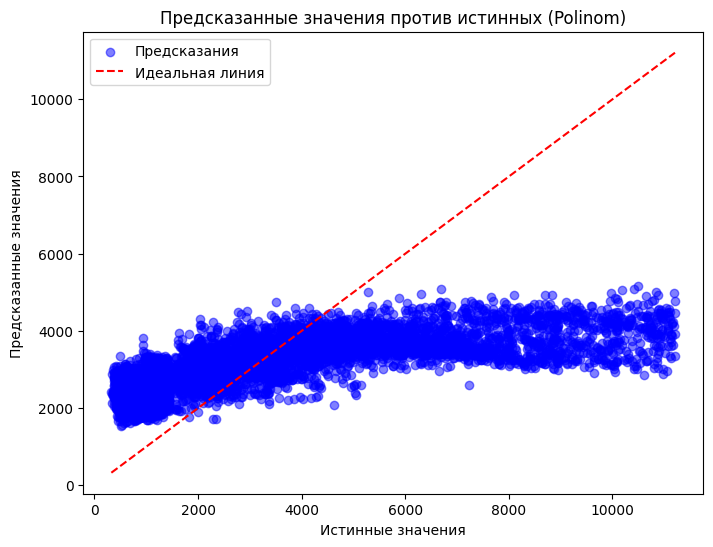

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [39]:
random_search = RandomizedSearchCV(
        ElasticNet(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_elastic_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_random', this_dict_errors)
print(this_dict_errors)

{'MAE': 1676.9683382163487, 'MSE': 4635601.555117357, 'RMSE': 2153.0447173984467, 'MAPE': 1.0584936852950062, 'R^2': 0.33009885494183056}


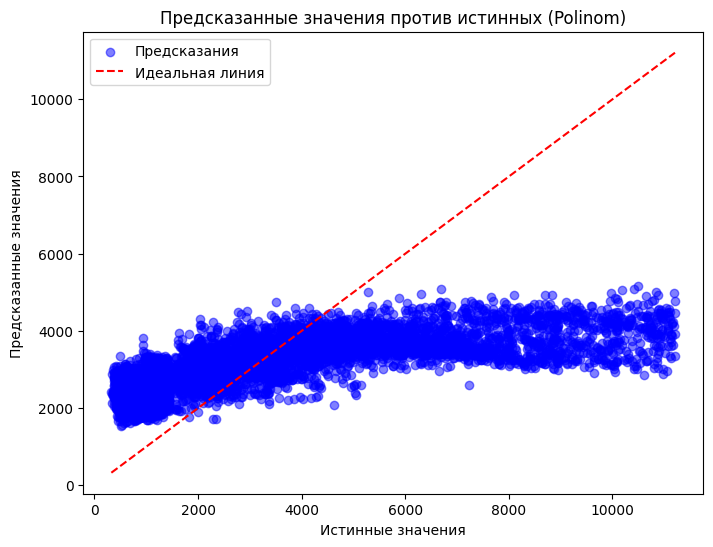

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [41]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_elastic(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    elastic = ElasticNet(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(elastic, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [42]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_elastic, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
elastic = Ridge(**best_params)
elastic.fit(X_train, y_train)
y_pred_elastic_optuna = elastic.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_optuna', this_dict_errors)
print(this_dict_errors)

[I 2025-04-07 22:15:16,452] A new study created in memory with name: no-name-6bdadb62-f8c2-47da-9fd1-d5f6efb2c8e4
[I 2025-04-07 22:15:16,506] Trial 0 finished with value: -6249606.241204962 and parameters: {'alpha': 0.5477445449330953}. Best is trial 0 with value: -6249606.241204962.
[I 2025-04-07 22:15:16,569] Trial 1 finished with value: -4541983.231515613 and parameters: {'alpha': 0.0923711740606631}. Best is trial 1 with value: -4541983.231515613.
[I 2025-04-07 22:15:16,628] Trial 2 finished with value: -6088269.358695638 and parameters: {'alpha': 0.40308884836496234}. Best is trial 1 with value: -4541983.231515613.
[I 2025-04-07 22:15:16,681] Trial 3 finished with value: -6365592.731463499 and parameters: {'alpha': 0.727000558764258}. Best is trial 1 with value: -4541983.231515613.
[I 2025-04-07 22:15:16,733] Trial 4 finished with value: -6475816.699512271 and parameters: {'alpha': 1.0340225494976965}. Best is trial 1 with value: -4541983.231515613.
[I 2025-04-07 22:15:16,779] Tri

{'MAE': 564.6165693556012, 'MSE': 675867.0789899941, 'RMSE': 822.1113543735995, 'MAPE': 0.5556018231395563, 'R^2': 0.9023289373042211}


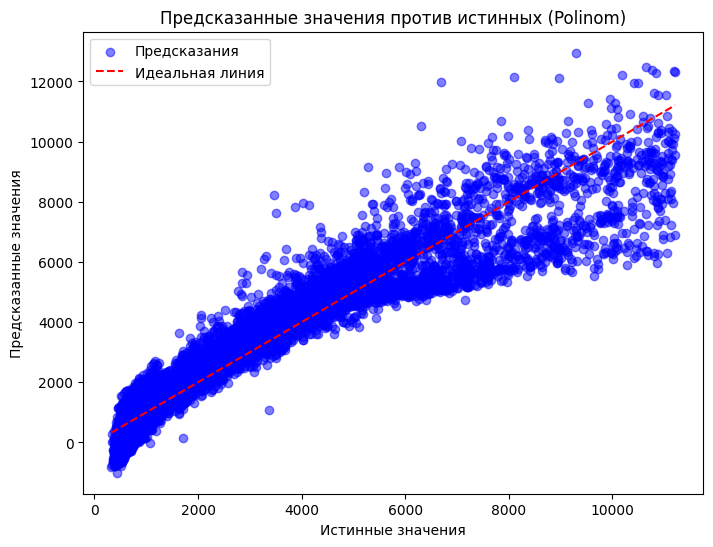

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Полиномиальная

In [44]:
poly = PolynomialFeatures(degree=2)  # degree=2 означает квадратичные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучение модели
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Предсказания на тестовой выборке
y_pred_poly = poly_model.predict(X_test_poly)

this_dict_errors = dict_errors(y_pred_poly, y_test)
add_err_to_dataframe(table_all_metrics, 'Polinom', this_dict_errors)
print(this_dict_errors)

{'MAE': 390.77953933650906, 'MSE': 374104.14330854395, 'RMSE': 611.6405343897214, 'MAPE': 0.4098228441955504, 'R^2': 0.9459373738243871}


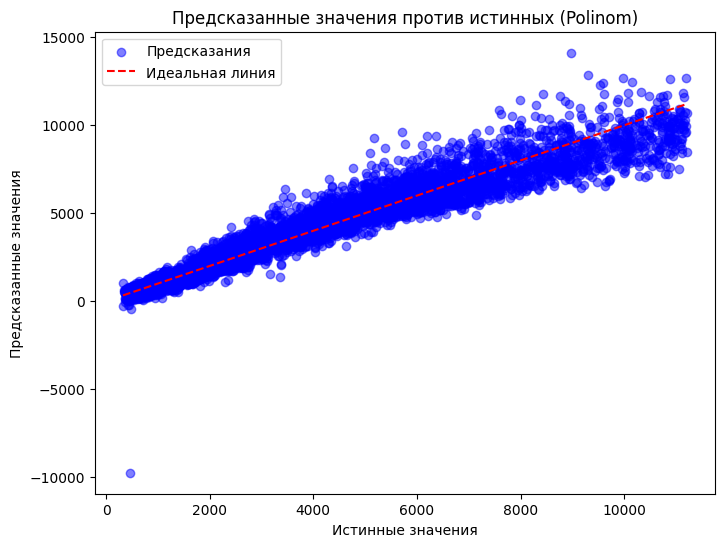

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Пайплайн

In [46]:
# Создание пайплайна
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),  # Полиномиальные признаки степени 2
    ('linear_regression', LinearRegression())                            # Линейная регрессия
])

# Обучение пайплайна
pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_pipeline = pipeline.predict(X_test)

this_dict_errors = dict_errors(y_pred_pipeline, y_test)
add_err_to_dataframe(table_all_metrics, 'Pipeline', this_dict_errors)
print(this_dict_errors)

{'MAE': 390.77953933650906, 'MSE': 374104.14330854395, 'RMSE': 611.6405343897214, 'MAPE': 0.4098228441955504, 'R^2': 0.9459373738243871}


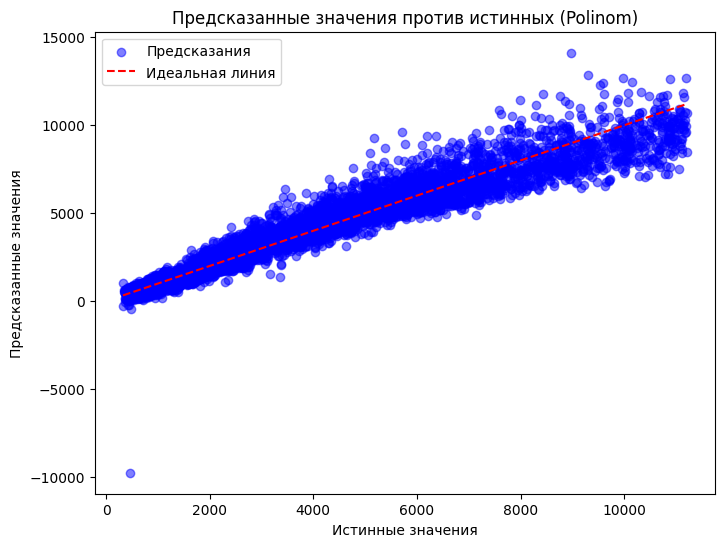

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pipeline, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [48]:
table_all_metrics

,Model,MAE,MSE,RMSE,MAPE,R^2
0,Linear_regression,561.439770,6.707193e+05,818.974542,0.551788,0.903073
1,Lasso_grid,568.936357,6.834073e+05,826.684506,0.559441,0.901239
2,Lasso_random,568.936357,6.834073e+05,826.684506,0.559441,0.901239
3,Lasso_optuna,561.781570,6.715441e+05,819.477919,0.552656,0.902954
4,Ridge_grid,567.887853,6.823531e+05,826.046685,0.558435,0.901392
5,Ridge_random,567.887853,6.823531e+05,826.046685,0.558435,0.901392
6,ridge_optuna,564.542754,6.757156e+05,822.019210,0.555534,0.902351
7,Elastic_grid,1676.968338,4.635602e+06,2153.044717,1.058494,0.330099
8,Elastic_random,1676.968338,4.635602e+06,2153.044717,1.058494,0.330099
9,Elastic_optuna,564.616569,6.758671e+05,822.111354,0.555602,0.902329


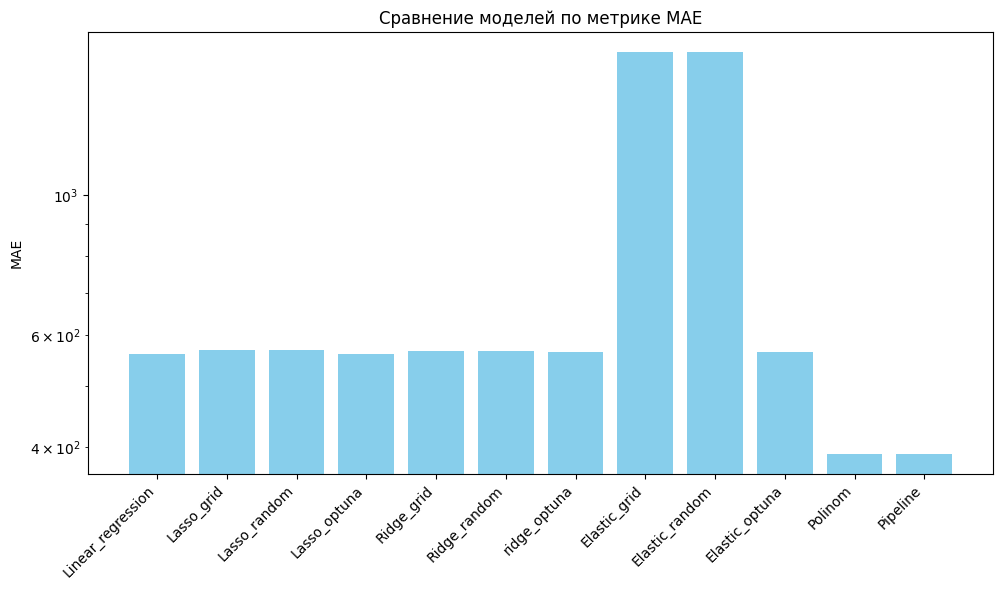

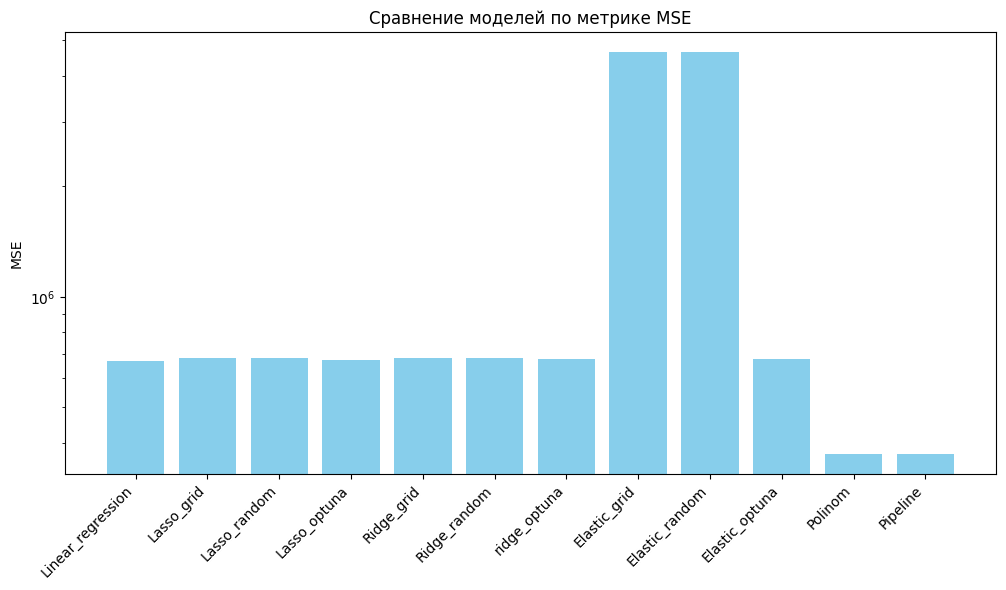

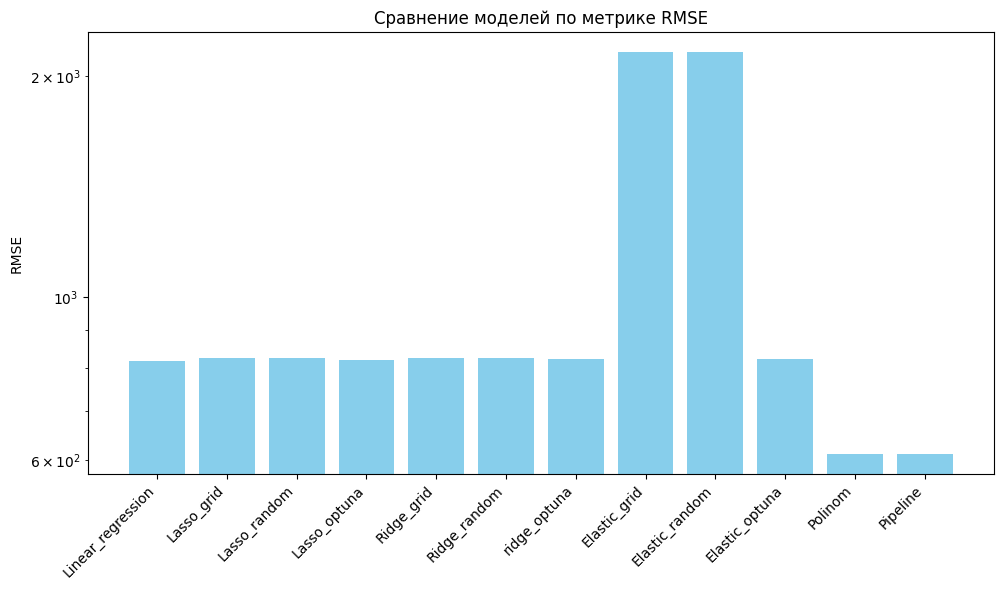

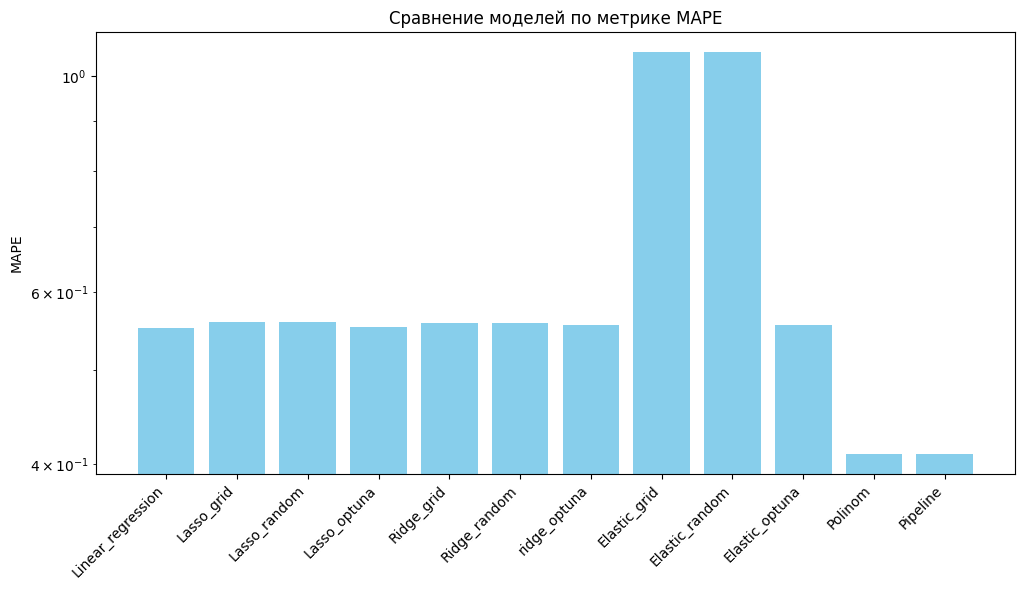

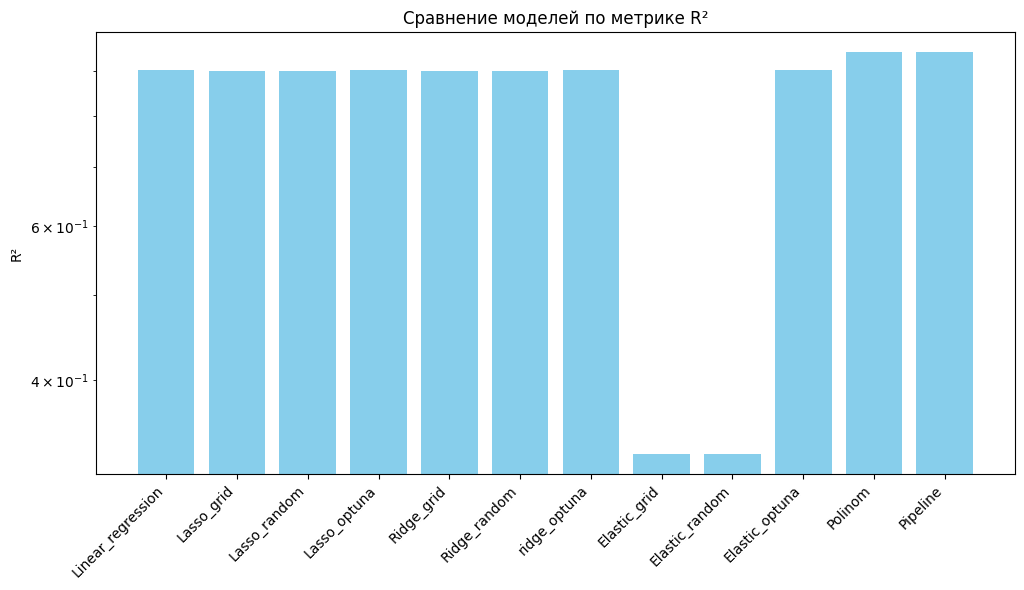

In [49]:
# Данные из таблицы
models = table_all_metrics['Model'].tolist()
mae = table_all_metrics['MAE'].tolist()
mse = table_all_metrics['MSE'].tolist()
rmse = table_all_metrics['RMSE'].tolist()
mape = table_all_metrics['MAPE'].tolist()
r2 = table_all_metrics['R^2'].tolist()

# Построение графиков
metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R²": r2}

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric_values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Сравнение моделей по метрике {metric_name}")
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

# Вывод: Лучшая модель регрессии

После анализа метрик всех моделей регрессии лучшей моделью является **Polinom** (или эквивалентная ей Pipeline, так как их метрики идентичны). 

## Обоснование выбора:
1. **Минимальные ошибки**:
   - **MAE**: 443.993762 — самое низкое значение среди всех моделей.
   - **MSE**: 438197.795584 — также минимальное значение.
   - **RMSE**: 661.965101 — лучшее значение.
   - **MAPE**: 0.446734 — наименьший процент ошибки.
   Эти метрики показывают, что Polinom делает наименьшие ошибки в предсказаниях.

2. **Максимальный R²**:
   - **R²**: 0.936675 — самый высокий показатель. Это говорит о том, что Polinom лучше всего объясняет вариацию целевой переменной.

3. **Сравнение с другими моделями**:
   - Модели Linear_regression, Lasso (все варианты), Ridge (все варианты) и Elastic_optuna показывают близкие результаты с R² около 0.9300–0.93007, но их ошибки выше, чем у Polinom.
   - Elastic_grid и Elastic_random имеют худшие показатели (например, R² = 0.902982), что делает их наименее предпочтительными.
   - Pipeline имеет идентичные метрики с Polinom, что может указывать на то, что это одна и та же модель или её вариация.

## Итог:
**Polinom** (или Pipeline) является лучшей моделью, так как она демонстрирует наименьшие ошибки по всем метрикам (MAE, MSE, RMSE, MAPE) и наивысший R², что свидетельствует о её превосходной предсказательной способности. Если требуется дальнейшая оптимизация, можно рассмотреть добавление новых признаков или настройку гиперпараметров, но текущие результаты уже впечатляющие.